# Восстановление золота из руды

## Описание проекта

Данные расположены в нескольких файлах:
 - gold_recovery_full.csv — исходные данные.
 - gold_recovery_train.csv — обучающая выборка;
 - gold_recovery_test.csv — тестовая выборка;

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

В данных есть время и дата (признак 'date'). Соседние по времени параметры могут быть похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей, включая целевые.

В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

#### Инструкция по выполнению проекта

1. Подготовьте данные

    1.1 Откройте файлы и изучите их.
    
    1.2 Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.
    
    1.3 Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
    
    1.4 Проведите предобработку данных.
    
2. Проанализируйте данные

    2.1 Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.
    
    2.2 Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.
    
    2.3 Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.
    
3. Постройте модель

    3.1 Напишите функцию для вычисления итоговой sMAPE.
    
    3.2 Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

## <a id='content'>Содержание</a>
1. <a href='#step-1'>Подготовка данных</a>
2. <a href='#step-2'>Модель</a>
3. <a href='#step-3'>Анализ данных</a>
4. <a href='#final-conclusion'>Общий вывод</a>

## Технологический процесс

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

<img src='https://pictures.s3.yandex.net/resources/viruchka_1576238830.jpg'>

Опишем каждую стадию:
1. Флотация

    Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
    На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
    
2. Очистка

    Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

### Описание данных

**Технологический процесс**

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate **— ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

**Параметры этапов**

- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

### Наименование признаков

Наименование признаков должно быть такое:

`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики
Возможные значения для блока `[тип_параметра]`:
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

### Расчёт эффективности
Вам нужно смоделировать процесс восстановления золота из золотосодержащей руды.

Эффективность обогащения рассчитывается по формуле

<img src='https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg'>

где:
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

**Метрика качества**
Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.

Метрика sMAPE вычисляется так:

<img src='https://pictures.s3.yandex.net/resources/smape_1576238825.jpg'>

Нужно спрогнозировать сразу две величины:
* эффективность обогащения чернового концентрата `rougher.output.recovery`;
* эффективность обогащения финального концентрата `final.output.recovery`.

Итоговая метрика складывается из двух величин:
<img src='https://pictures.s3.yandex.net/resources/_smape_1576238814.jpg'>

# <a id='step-1'>1. Подготовка данных</a>

In [1]:
# Импортируем нужные нам модули.
%matplotlib inline
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.dummy import DummyRegressor

In [2]:
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')

df_full.shape, df_train.shape, df_test.shape

((22716, 87), (16860, 87), (5856, 53))

In [3]:
df_full.info()
df_full.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
df_train.info()
df_train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [5]:
df_test.info()
df_test.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


Рассчитаем MAE, для этого выберем только те признаки, которые участвуют в рассчете, а также отбросим `recovery` с пропусками.

In [6]:
# MAE для флотации
df_mae = df_train.loc[:, ['rougher.output.concentrate_au', 
                          'rougher.input.feed_au', 
                          'rougher.output.tail_au', 
                          'rougher.output.recovery']].dropna(
    subset = ['rougher.output.recovery'])

In [7]:
# MAE для финальной очистки
df_mae_2 = df_train.loc[:, ['final.output.concentrate_au', 
                          'rougher.input.feed_au', 
                          'final.output.tail_au', 
                          'final.output.recovery']].dropna(
    subset = ['final.output.recovery'])

Заполним пропуски ближайшими значениями.

In [8]:
df_mae.fillna(method = 'ffill', inplace=True)
df_mae_2.fillna(method = 'ffill', inplace=True)

In [9]:
def recovery_calculation(C, F, T):
    """
    Рассчет recovery по заданным значениям C, F, T
    Если значение F равно нулю выводит ноль
    """
    if F != 0:
        return ((C*(F-T)) / (F*(C-T)))*100
    return 0

In [10]:
def rougher_recovery(row):
    """
    Функция выделяет из датасета необходимые для рассчета recovery признаки для этапа флотации
    """
    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    return recovery_calculation(C, F, T)

In [11]:
def final_recovery(row):
    """
    Функция выделяет из датасета необходимы для рассчета recovery признаки для этапа финальной очистки
    """
    C = row['final.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['final.output.tail_au']
    return recovery_calculation(C, F, T)

In [12]:
df_mae['rougher.output.recovery_new'] = df_mae.apply(rougher_recovery, axis =1)
print('MAE рассчитанных и заданных значений recovery для этапа флотации:')
mean_absolute_error(df_mae['rougher.output.recovery'], df_mae['rougher.output.recovery_new'])

MAE рассчитанных и заданных значений recovery для этапа флотации:


9.444891926100695e-15

In [13]:
df_mae_2['final.output.recovery_new'] = df_mae_2.apply(final_recovery, axis =1)
print('MAE рассчитанных и заданных значений recovery для этапа финальной очистки:')
mean_absolute_error(df_mae_2['final.output.recovery'], df_mae_2['final.output.recovery_new'])

MAE рассчитанных и заданных значений recovery для этапа финальной очистки:


8.158251945945868e-15

#### Вывод
Значения MAE стремится к нулю, значит, значения `recovery`, представленные в датасете, верны. Ненулевой MAE вероятно связан с тем, что были заполнены пропуски в значениях, участвовавших в рассчёте.

Посмотрим на признаки, которые не представлены в тестовой выборке.

In [14]:
df_train.drop(df_test.columns, axis = 1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 34 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.output.concentrate_ag                 16778 non-null float64
primary_cleaner.output.concentrate_pb                 16502 non-null float64
primary_cleaner.output.concentrate_sol      

В тестовой выборке не представлены параметры типа `output` и `calculation`. Это параметры измерение которых возможно только после обработки сырья, и неправильно было бы их использовать для обучения модели предсказания.

Проведем предобработку тренировочной и тестовой выборок, так как обучение модели будет производиться на них. Сначала исключим из тренировочной выборки строки с пропусками в значениях целевых признаков.

In [15]:
before = len(df_train)
df_train = df_train.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'])
after = len(df_train)
print('После исключения пропусков в целевых признаках осталось {:.2f}% датасета'.format((after/before)*100))

После исключения пропусков в целевых признаках осталось 83.92% датасета


Пропуски в признаках заполним ближайшими значениями.

In [16]:
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14149 non-null float64
final.output.concentrate_pb                           14149 non-null float64
final.output.concentrate_sol                          14149 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14149 non-null float64
final.output.tail_sol                                 14149 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14149 non-null float64
primary_cleaner.input.depressant             

In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5856 non-null float64
primary_cleaner.input.depressant              5856 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5856 non-null float64
primary_cleaner.state.floatbank8_a_air        5856 non-null float64
primary_cleaner.state.floatbank8_a_level      5856 non-null float64
primary_cleaner.state.floatbank8_b_air        5856 non-null float64
primary_cleaner.state.floatbank8_b_level      5856 non-null float64
primary_cleaner.state.floatbank8_c_air        5856 non-null float64
primary_cleaner.state.floatbank8_c_level      5856 non-null float64
primary_cleaner.state.floatbank8_d_air        5856 non-null float64
primary_cleaner.state.floatbank8_d_level      5856 non-null float64
rougher.in

Приведем столбец `date` в трех датасетах к формату DateTime и округлим значения до одного часа.

In [19]:
def to_date(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
    df['date'] = df['date'].dt.round('1H')

In [20]:
to_date(df_train)
to_date(df_test)
to_date(df_full)

Добавим в тестовый датасет значения целевых признаков из полного датасета. Строки с отсутствующим целевым признаком исключаем.

In [21]:
columns_to_merge = ['rougher.output.recovery', 'date', 'final.output.recovery']
df_test = df_test.merge(df_full[columns_to_merge], on='date').dropna(subset=columns_to_merge)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5855
Data columns (total 55 columns):
date                                          5290 non-null datetime64[ns]
primary_cleaner.input.sulfate                 5290 non-null float64
primary_cleaner.input.depressant              5290 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5290 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
ro

### Вывод
1. Данные успешно загружены и изучены.
2. Из тренировочного датасета исключены строки с отсутствующими целевыми признаками.
3. Пропуски в тренировочном и тестовом датасете заполнены ближайшими значениями.
4. Столбец `date` переведен в тип DateTime.
5. В тестовый датасет добавлены целевые признаки.

# <a id='step-2'>2. Анализ данных</a>

Проанализируем изменение концентраций металлов на разных стадиях очистки.

In [22]:
metals_list = ['ag', 'au', 'pb', 'sol']
stages = [
    'rougher.input.feed_', 
    'rougher.output.concentrate_', 
    'primary_cleaner.output.concentrate_', 
    'final.output.concentrate_']

In [23]:
def plot_box(df):
    """
    Функция строит ящики с усами для каждого металла на всех этапах очистки
    """
    plt_columns = df.columns[df.columns.str.contains('concentrate_') | df.columns.str.contains('input')]
    
    for metal in metals_list:
        order=[]
        for i in range(len(stages)):
            order.append(stages[i]+metal)
        plt_metal = plt_columns[plt_columns.str.contains(metal)]
        df_plot = df[plt_metal]
        sns.boxplot(data = df_plot, orient = 'h', order=order)
        label = 'Изменение концентрации ' + metal + ' на разных этапах обработки'
        plt.title(label = label, fontsize=15)
        plt.show()

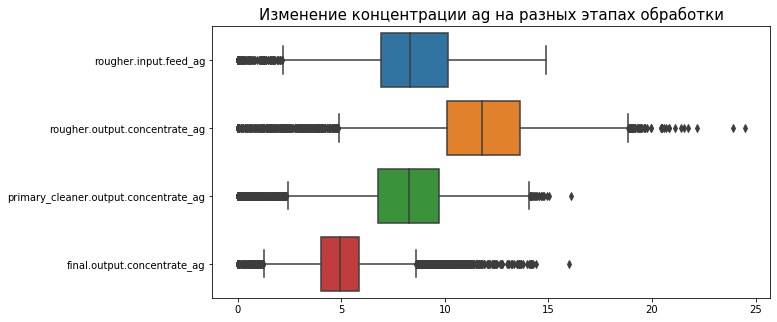

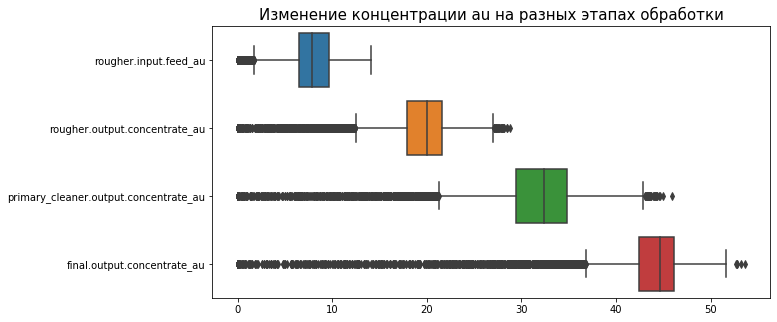

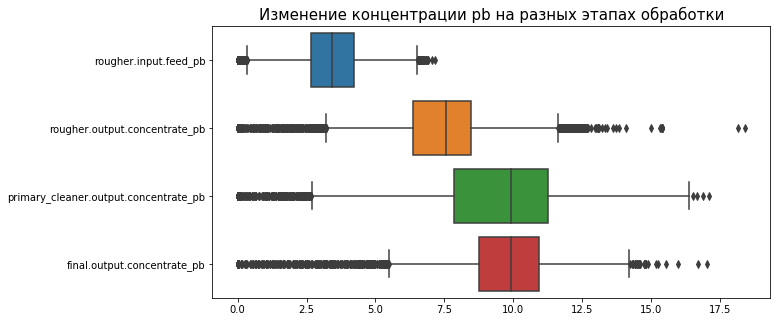

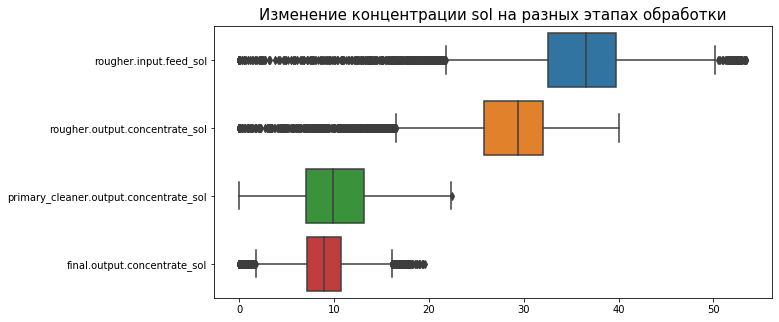

In [24]:
plt.rcParams['figure.figsize']=(10,5)
plot_box(df_full)

### Выводы: 
1. Концентрация золота с каждым этапам увеличивается.
2. Концентрация примесей sol с каждым этапом очистки уменьшается.
3. Концентрация свинца после флотации и первого этапа очистки увеличивается, но на последнем этапе остается неизменной, возможно это связано с близкими, в некоторой части, свойствами с золотом.
4. Концентрация серебра к последнему этапу очистки снижается.
5. Заметно довольно большое количество выбросов для каждого из признаков.

Сравним распределения гранул сырья.

In [25]:
def conf_int(df, df_2):
    """
    Функция строит ящик с усами и гистограмму распределения, а также считает среднее и доверительный интервал
    размеров гранул сырья.
    """
    fig, ax = plt.subplots()
    plt.xlim([0,400])
    sx = sns.boxplot(x='rougher.input.feed_size',data = df, orient = 'h', color="gray")
    plt.show()
    plt.xlim([0,400])
    sns.boxplot(x='rougher.input.feed_size',data = df_2, orient = 'h')
    plt.show()
    sns.distplot(df['rougher.input.feed_size'], kde=True, hist_kws={"alpha": 0.2, "color": "y"})
    sns.distplot(df_2['rougher.input.feed_size'], kde=True, hist_kws={"alpha": 0.2})
    plt.show()
    for frame in [df, df_2]:
        print('Среднее для выборки равно:', frame['rougher.input.feed_size'].mean())
        q_025 = frame['rougher.input.feed_size'].quantile(0.025)
        q_975 = frame['rougher.input.feed_size'].quantile(0.975)
        print('При этом 95% значений находится в интервале: ({:.2f}:{:.2f})'.format(q_025, q_975))
    print()

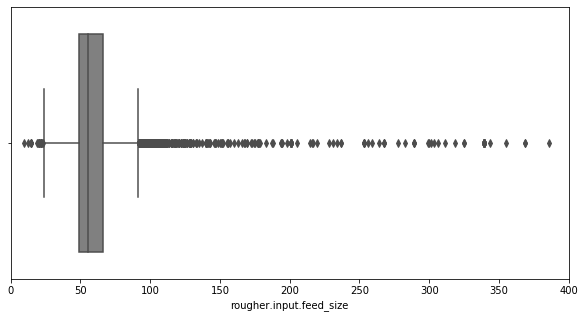

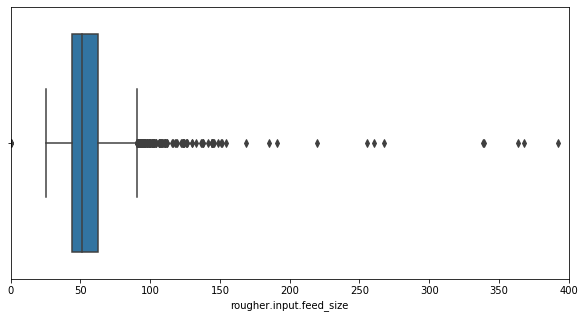

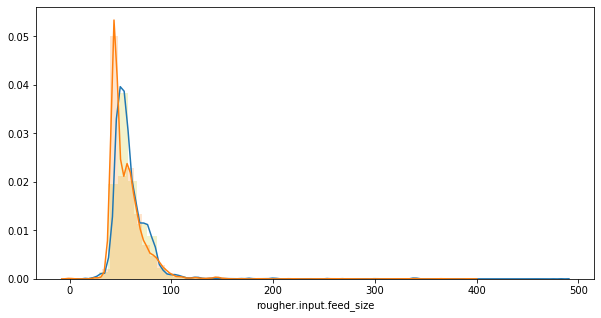

Среднее для выборки равно: 60.23985599255732
При этом 95% значений находится в интервале: (40.08:97.49)
Среднее для выборки равно: 55.95275402889513
При этом 95% значений находится в интервале: (39.72:94.19)



In [26]:
conf_int(df_train, df_test)

### Вывод
Значения размеров гранул сырья для тестовой и тренировочной выборок несколько отличаются. Средние значения 5, при этом 95% значений тестовой и тренировочной выборок лежат примерно в одних границах.

Исследуем суммарную концентрацию веществ на всех этапах очистки.

In [27]:
def summ_conc(row):
    """
    Функция перебирает значения концентраций металлов на разных этапах формирует колонку
    [название этапа]_sum с суммарной концентрацией металлов на этом этапе.
    """
    for stage in stages:
        conc = 0
        for metal in metals_list:
            name = stage + metal
            conc += row[name]
        name_sum = stage + 'sum'
        row[name_sum] = conc
    return row

Дополним полный датасет значениями общих концентраций.

In [28]:
df_full = df_full.apply(summ_conc, axis=1)

In [29]:
def violin_plot(df):
    """
    Функция строит график изменения суммарной концентрации веществ на всех этапах обработки, 
    начиная с исходного состояния.
    """
    df_supp = df.loc[:, df.columns.str.contains('sum')]
    sns.violinplot(data = df_supp, orient = 'h')
    label = 'Изменение суммарной концентрации на разных этапах обработки.'
    plt.title(label = label, fontsize=15)
    plt.show()

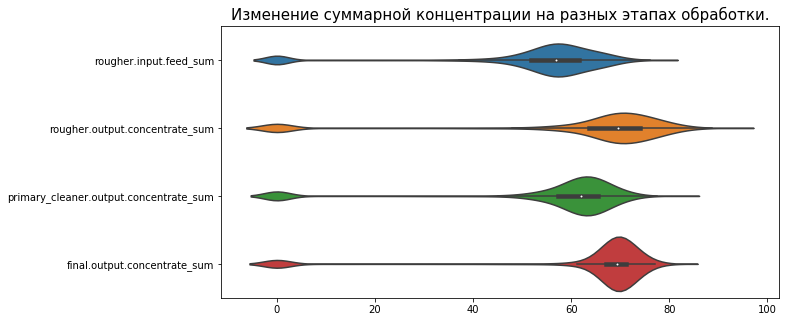

In [30]:
violin_plot(df_full)

На графиках заметно большое количество выбросов в районе концентрации от 0 до 1. Чтобы эти выбросы не влияли на предсказания модели, исключим их.

In [31]:
df_full_new = df_full[(
    df_full['rougher.input.feed_sum'] > 1) & (
    df_full['rougher.output.concentrate_sum'] > 1) & (
    df_full['primary_cleaner.output.concentrate_sum'] > 1) & (
    df_full['final.output.concentrate_sum'] > 1 )]

In [32]:
print('После удаления выбросов осталось {:.2f}% датасета'.format((len(df_full_new) / len(df_full)) * 100))

После удаления выбросов осталось 82.47% датасета


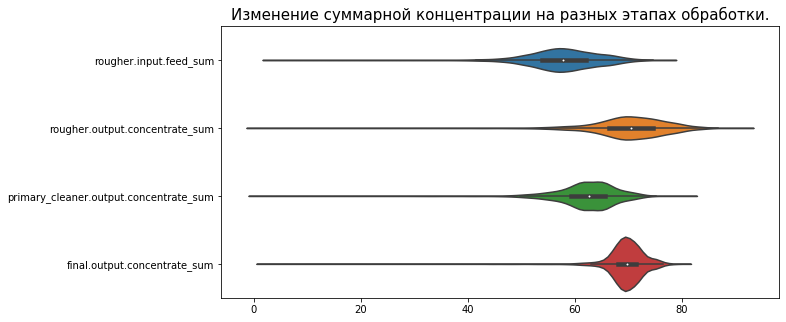

In [33]:
violin_plot(df_full_new)

Также исключим строки с выбросами из тестовой и тренировочной выборок.

In [34]:
def drop_bad(df):
    """
    Функция фильтрует датасет по строкам df_full_new и считает количество отброшеных строк.
    """
    
    print('Размер датафрейма до исключения выбросов:', len(df))
    df_supp = df_full.drop(df_full_new.index)
    df_new = df.drop(df_supp.index, errors = 'ignore')
    print('Размер датафрейма после исключения выбросов:', len(df_new))
    print('После удаления выбросов осталось {:.2f}% датасета'.format((len(df_new)/ len(df))*100))
    return df_new

In [35]:
df_train_new = drop_bad(df_train)

Размер датафрейма до исключения выбросов: 14149
Размер датафрейма после исключения выбросов: 12486
После удаления выбросов осталось 88.25% датасета


In [36]:
df_test_new = drop_bad(df_test)

Размер датафрейма до исключения выбросов: 5290
Размер датафрейма после исключения выбросов: 4279
После удаления выбросов осталось 80.89% датасета


### Вывод

1. Исследовано изменение концентрации металлов на разных этапах очистки.
2. Исследованы набор значений размеров гранул сырья на тренировочной и тестовой выборках.
3. Исследована суммарная концентрация веществ на разных этапах обработки.
4. Выявлены значительные выбросы в суммарной концентрации в пределах 1.
5. Из полной, тренировочной и тестовых выборок исключены выбросы.

# <a id='step-3'>3. Модель</a>

Напишем функцию рассчета sMAPE.

In [37]:
def sMAPE(true, pred):
    """
    Функция по предсказаниям и значению целевого признака считает велечину sMAPE
    """
    pred = pd.Series(pred, true.index)
    x = (abs(true-pred) / ((abs(true) + abs(pred))/2)).sum()/len(true)
    return x*100

In [38]:
def final_sMAPE(true, pred):
    """
    Функция считает итоговый sMAPE
    """
    return 0.25*sMAPE(
        true['rougher.output.recovery'], pred[:,0]) + 0.75*sMAPE(
        true['final.output.recovery'], pred[:,1])

Исключим из тренировочной выборки колонки отсутствующие в тестовой выборке.

In [39]:
columns_to_drop = df_train_new.drop(df_test_new.columns, axis = 1).columns

In [40]:
df_train_new = df_train_new.drop(columns_to_drop, axis = 1)

Исключим из тестовой и тренировочных выборок колонку `date`.

In [41]:
df_train_new.drop('date', axis =1, inplace = True)
df_test_new.drop('date', axis =1, inplace = True)

Выделим признаки и целевой признак.

In [42]:
def split_df(df):
    """
    Функция разделяет и выделяет из датафрейма признаки и
    целевой признак.
    """
    # Разделим признаки и целевой признак.
    features = df.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1)
    target = df[['rougher.output.recovery', 'final.output.recovery']]
     
    return features, target

In [43]:
features_train, target_train = split_df(df_train_new)
features_test, target_test = split_df(df_test_new)

Проведем масштабирование признаков.

In [44]:
scaler = StandardScaler()
scaler.fit(features_train[features_train.columns])

features_train[features_train.columns] = scaler.transform(features_train[features_train.columns])
features_test[features_test.columns] = scaler.transform(features_test[features_test.columns])

Создадим метрику для использования в кросс-валидации и поиске глобальных параметров модели. Она будет основываться на ранее созданной функции рассчета final_sMAPE.

In [45]:
smape_scorer = make_scorer(final_sMAPE, greater_is_better = False)

Функция для кросс-валидации:

In [46]:
def cr_val_sc(model, features, target):
    """
    Функция проводит кросс-валидацию и считает среднюю метрику.
    """
    score = cross_val_score(
        model, 
        features, 
        target, 
        cv=5, 
        scoring = smape_scorer, 
        error_score='raise')
    
    final_score = score.mean()
    return final_score

Для построения будем использовать следующие модели:

In [47]:
model_linear = LinearRegression()

model_forest = RandomForestRegressor(
    random_state = 12345, 
    n_jobs=-1)

model_tree = DecisionTreeRegressor(
    random_state = 12345)

Проведем кросс-валидацию линейной модели.

In [48]:
cr_val_sc(model_linear, features_train, target_train)

-11.709920058625967

Для оставшихся моделей, для подбора гиперпараметров, будем использовать GredSearchCV, в который встроена кросс-валидация.

In [49]:
params_forest = {
    'n_estimators': [50,300,50],
    'max_depth':[5,15],
    'max_features' : [1,20, 2]
}

In [50]:
params_tree = {   
    'max_depth':[1,20]  
}

Обучим модель решающего дерева.

In [51]:
CV_tree = GridSearchCV(
    model_tree, 
    param_grid=params_tree, 
    scoring=smape_scorer, 
    cv=5)

CV_tree.fit(features_train, target_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=12345,
                                             splitter='best'),
             iid='warn', n_jobs=None, param_grid={'max_depth': [1, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(final_sMAPE, greater_is_better=False),
             verbose=0)

In [52]:
print('Лучшее значение Итогового sMAPE:', CV_tree.best_score_)
print('С параметром', CV_tree.best_params_)

Лучшее значение Итогового sMAPE: -10.965990205097505
С параметром {'max_depth': 1}


Обучим модель случайного леса.

In [53]:
%%time
CV_forest = GridSearchCV(
    model_forest, 
    param_grid=params_forest, 
    scoring=smape_scorer, 
    cv=5)

CV_forest.fit(features_train, target_train)

CPU times: user 11min 4s, sys: 424 ms, total: 11min 4s
Wall time: 11min 7s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=-1,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_start=False),
             iid='warn', n_jobs=None,
            

In [54]:
print('Лучшее значение Итогового sMAPE:',CV_forest.best_score_)
print('С параметром', CV_forest.best_params_)

Лучшее значение Итогового sMAPE: -9.36860081269276
С параметром {'max_depth': 5, 'max_features': 20, 'n_estimators': 300}


### Вывод
Судя по значению итогового sMAPE, лучшие предсказания даёт модель случайного леса, её и используем при построении финальной модели.

Обучим наилучшую модель с лучшими гиперпараметрами и посчитаем итоговый sMAPE на тестовой выборке.

In [55]:
model_final = RandomForestRegressor(
    random_state = 12345, 
    n_estimators=300, 
    max_depth=5, 
    max_features=20, 
    n_jobs=-1)

model_final.fit(features_train, target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features=20, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
                      oob_score=False, random_state=12345, verbose=0,
                      warm_start=False)

In [56]:
predict = model_final.predict(features_test)
print('Лучшая модель показала итоговый sMAPE на тестовой выборке:', final_sMAPE(target_test, predict))

Лучшая модель показала итоговый sMAPE на тестовой выборке: 8.698748288719123


Для проверки адекватности модели, сравним ее с результатами работы DummyRegressor.

In [57]:
model_dummy = DummyRegressor(strategy="mean")
model_dummy.fit(features_train, target_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [58]:
predict_dummy = model_dummy.predict(features_test)
print('Dummy модель показала итоговый sMAPE на тестовой выборке:', final_sMAPE(target_test, predict_dummy))

Dummy модель показала итоговый sMAPE на тестовой выборке: 9.659867969858126


Результаты Dummy-модели несколько хуже полученных моделью случайного леса. Считаем, что лучшая модель адекватна.

### Вывод

1. Была написана функция для расчета sMAPE и итогового sMAPE.
2. Проведено выделение признаков и целевого признака.
3. Проведено масштабирование признаков.
4. Исключены признаки не влияющие на качесто моеделей, или те, которые отсутствуют в тестовой выборке.
5. Обучены модели линейной регрессии, регрессионного дерева решений, бэггинга дерева решений и регрессионного случайного леса.
6. Выбрана лучшая модель с гиперпараметрами, обеспечивающими минимальный финальный sMAPE.

## <a id='final-conclusion'>Общий вывод</a>

1. Проведена предобработка данных трёх датасетов.
2. Из выборок исключены выбросы, которые могли бы повлиять на качество построенных моделей.
3. Исследованы стадии очистки сырья.
4. Написаны функции рассчета требуемой метрики - итоговой sMAPE.
5. Построены три модели машинного обучения - линейной регрессии, случайного леса и дерева решений.
6. Проведена кросс-валидация и выбор гиперпараметров моделей.
7. Выбрана наилучшая модель с подходящими гиперпараметрами - регрессионный случайный лес с параметрами {'max_depth': 5, 'max_features': 20, 'n_estimators': 300}. Итоговый sMAPE при кросс-валидации равен 9.36.
8. Выбранная модель проверена на тестовой выборке. Значение итоговой sMAPE близко к значениям полученным при кросс-валлидации - 8.7.
9. Была обучена Dummy модель для проверки на адекватность. Предсказания дамми модели оказались хуже предсказаний модели случайного леса (9.6).

<a href='#content'>Назад к содержанию.</a>